In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.optimize import minimize_scalar
from prettytable import PrettyTable 

# 5.1

In [2]:
def cos_orthon(K,X,N):
    Phi=np.ones(N).reshape((-1,1))
    for i in range(1,K):
        temp_phi=(np.sqrt(2)*np.cos(np.pi*i*X)).reshape((-1,1))
        Phi=np.c_[Phi,temp_phi]
    return Phi

def mB(X,N,mu_1,sigma_1,mu_2,sigma_2):
    mb=0.5*stats.norm.pdf(X,mu_1,sigma_1)+0.5*stats.norm.pdf(X,mu_2,sigma_2)
    return mb.reshape((-1,1))

def mS(X,N):
    ms=np.where(np.logical_and(X>=0 , X<1/3),0.6,0)+np.where(np.logical_and(X>=1/3 , X<3/4),0.9,0)+np.where(np.logical_and(X>=3/4 , X<=1),204/120,0)
    return ms.reshape((-1,1))

def gen_x(N):
    return (np.arange(1,N+1)/(N+1))

def gen_y(N,mx,sigma,seed):
    np.random.seed(seed)
    u=np.random.randn(N,1)
    return mx+sigma*u

def gen_z(Phi,y,N):
    return (Phi.T@y)/N

def mle(Phi,z):
    return Phi@z

def ef(Phi,z,sigma,K,N):
    c=np.zeros(K)
    for k in range(0,K):
        c[k]=np.maximum(1-sigma*sigma/(z[k]*z[k]*N),0)
    return Phi@np.diag(c)@z

def sq_loss(m,est):
    return (m-est).T@(m-est)

def a(N,K,sigma,mu_1,sigma_1,mu_2,sigma_2,seed):
    x=gen_x(N)
    Phi=cos_orthon(K,x,N)
    m_B=mB(x,N,mu_1,sigma_1,mu_2,sigma_2)
    m_S=mS(x,N)
    y_B=gen_y(N,m_B,sigma,seed)
    y_S=gen_y(N,m_S,sigma,seed)
    z_B=gen_z(Phi,y_B,N)
    z_S=gen_z(Phi,y_S,N)
    mle_B=mle(Phi,z_B)    
    mle_S=mle(Phi,z_S)
    ef_B=ef(Phi,z_B,sigma,K,N) 
    ef_S=ef(Phi,z_S,sigma,K,N)
    loss_mle_B=sq_loss(m_B,mle_B)
    loss_mle_S=sq_loss(m_S,mle_S)
    loss_ef_B=sq_loss(m_B,ef_B)
    loss_ef_S=sq_loss(m_S,ef_S)
    return loss_mle_B,loss_mle_S,loss_ef_B,loss_ef_S

In [3]:
print(a(1000,20,0.5,0.4,0.12,0.7,0.08,100))

(array([[5.77230947]]), array([[9.31144325]]), array([[4.57792296]]), array([[10.0121807]]))


Above values are "loss_mle_B","loss_mle_S","loss_ef_B","loss_ef_S" respectively.

# 5.2

In [6]:
def med(a):
    n=a.size
    m=np.ceil(n/2)
    return np.sort(a)[int(m)]

def plot(Type,seed,sigma,mu_1,sigma_1,mu_2,sigma_2,N,K):
    #type 0 : mleB，1 : mleS，2 : efB，3 : efS, 4:stB，5:stS
    x=gen_x(N)
    Phi=cos_orthon(K,x,N)
    m_B=mB(x,N,mu_1,sigma_1,mu_2,sigma_2)
    m_S=mS(x,N)
    y_B=gen_y(N,m_B,sigma,seed)
    y_S=gen_y(N,m_S,sigma,seed)
    z_B=gen_z(Phi,y_B,N)
    z_S=gen_z(Phi,y_S,N)
    if Type==0:
        est=mle(Phi,z_B)
        plt.plot(m_B,"r")
        plt.plot(est,"b")
        plt.title('mle_B')
        plt.show()
    elif Type==1:
        est=mle(Phi,z_S)
        plt.plot(m_S,"r")
        plt.plot(est,"b")
        plt.title('mle_S')
        plt.show()
    elif Type==2:
        est=ef(Phi,z_B,sigma,K,N)
        plt.plot(m_B,"r")
        plt.plot(est,"b")
        plt.title('ef_B')
        plt.show()
    elif Type==3:
        est=ef(Phi,z_S,sigma,K,N)
        plt.plot(m_S,"r")
        plt.plot(est,"b")
        plt.title('ef_S')
        plt.show()
    elif Type==4:
        lam=gen_lam(N,K,sigma,z_B)
        est=st(Phi,z_B,lam)
        plt.plot(m_B,"r")
        plt.plot(est,"b")
        plt.title('st_B')
        plt.show()
    elif Type==5:
        lam=gen_lam(N,K,sigma,z_S)
        est=st(Phi,z_S,lam)
        plt.plot(m_S,"r")
        plt.plot(est,"b")     
        plt.title('st_S')
        plt.show()

def b(N,K,sigma,mu_1,sigma_1,mu_2,sigma_2,sample_num):
    loss_mle_B=np.zeros(sample_num)
    loss_mle_S=np.zeros(sample_num)
    loss_ef_B=np.zeros(sample_num)
    loss_ef_S=np.zeros(sample_num)
    for i in range(0,sample_num):
        loss_mle_B[i],loss_mle_S[i],loss_ef_B[i],loss_ef_S[i]=a(N,K,sigma,mu_1,sigma_1,mu_2,sigma_2,i)
    ave_loss_mle_B=np.average(loss_mle_B)
    ave_loss_mle_S=np.average(loss_mle_S)
    ave_loss_ef_B=np.average(loss_ef_B)
    ave_loss_ef_S=np.average(loss_ef_S)
    table=PrettyTable(["","B","S"])
    table.add_row(["mle",ave_loss_mle_B,ave_loss_mle_S])
    table.add_row(["ef",ave_loss_ef_B,ave_loss_ef_S])
    print(table)
    plot(0,np.where(loss_mle_B==med(loss_mle_B))[0],sigma,mu_1,sigma_1,mu_2,sigma_2,N,K)
    plot(1,np.where(loss_mle_S==med(loss_mle_S))[0],sigma,mu_1,sigma_1,mu_2,sigma_2,N,K)
    plot(2,np.where(loss_ef_B==med(loss_ef_B))[0],sigma,mu_1,sigma_1,mu_2,sigma_2,N,K)
    plot(3,np.where(loss_ef_S==med(loss_ef_S))[0],sigma,mu_1,sigma_1,mu_2,sigma_2,N,K)

+-----+-------------------+-------------------+
|     |         B         |         S         |
+-----+-------------------+-------------------+
| mle | 4.982484699489192 | 8.671544271297181 |
|  ef | 3.876991873884056 |  8.67300433824821 |
+-----+-------------------+-------------------+


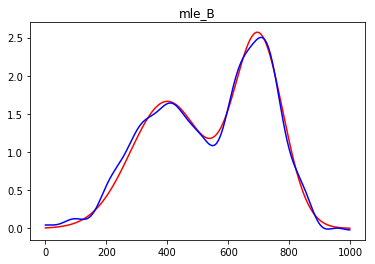

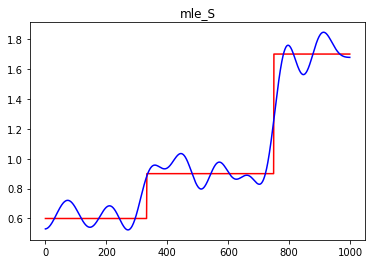

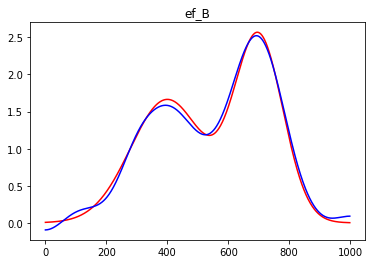

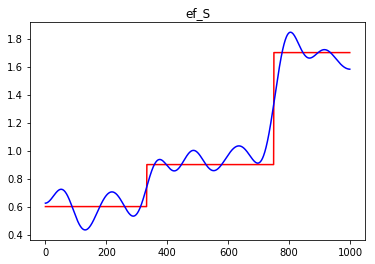

In [7]:
b(1000,20,0.5,0.4,0.12,0.7,0.08,1000)

From the data we can find that the mean squared loss for each type of estimation method is different, and the EF estimation has better performance compared with MLE.

The plots are showing above and the blue curve is our estimation and the red curve is the original data.

From the plots we can discover that our estimation fits the data well. The fitting result is better for data j = B.

# 5.3

In [8]:
def st(Phi,z,lam):
    theta=np.where(z>0,1,-1)*np.maximum(np.abs(z)-lam*np.ones_like(z),np.zeros_like(z))
    return Phi@theta

def r_sure(N,K,sigma,z):
    v=lambda lam: K*sigma*sigma/N-2*sigma*sigma/N*np.sum(np.where(np.abs(z)<=lam,1,0))+np.sum(np.minimum(z*z,lam*lam*np.ones_like(z)))
    return v

def gen_lam(N,K,sigma,z):
    mini=minimize_scalar(r_sure(N,K,sigma,z),method='Golden')
    return mini.x

def c_1(N,K,sigma,mu_1,sigma_1,mu_2,sigma_2,seed):
    x=gen_x(N)
    Phi=cos_orthon(K,x,N)
    m_B=mB(x,N,mu_1,sigma_1,mu_2,sigma_2)
    m_S=mS(x,N)
    y_B=gen_y(N,m_B,sigma,seed)
    y_S=gen_y(N,m_S,sigma,seed)
    z_B=gen_z(Phi,y_B,N)
    z_S=gen_z(Phi,y_S,N)
    lam_B=gen_lam(N,K,sigma,z_B)
    lam_S=gen_lam(N,K,sigma,z_S)
    st_B=st(Phi,z_B,lam_B)    
    st_S=st(Phi,z_S,lam_S)
    loss_st_B=sq_loss(m_B,st_B)
    loss_st_S=sq_loss(m_S,st_S)
    return loss_st_B,loss_st_S

def c_2(N,K,sigma,mu_1,sigma_1,mu_2,sigma_2,sample_num):
    loss_st_B=np.zeros(sample_num)
    loss_st_S=np.zeros(sample_num)
    for i in range(0,sample_num):
        loss_st_B[i],loss_st_S[i]=c_1(N,K,sigma,mu_1,sigma_1,mu_2,sigma_2,i)
    ave_loss_st_B=np.average(loss_st_B)
    ave_loss_st_S=np.average(loss_st_S)
    table=PrettyTable(["","B","S"])
    table.add_row(["st",ave_loss_st_B,ave_loss_st_S])
    print(table)
    plot(4,np.where(loss_st_B==med(loss_st_B))[0],sigma,mu_1,sigma_1,mu_2,sigma_2,N,K)
    plot(5,np.where(loss_st_S==med(loss_st_S))[0],sigma,mu_1,sigma_1,mu_2,sigma_2,N,K)

+----+-------------------+-------------------+
|    |         B         |         S         |
+----+-------------------+-------------------+
| st | 4.499200133178653 | 8.551729401957203 |
+----+-------------------+-------------------+


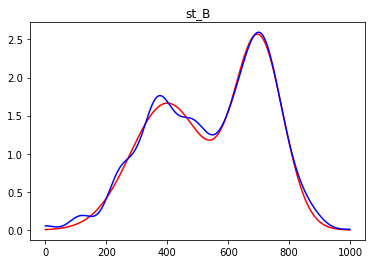

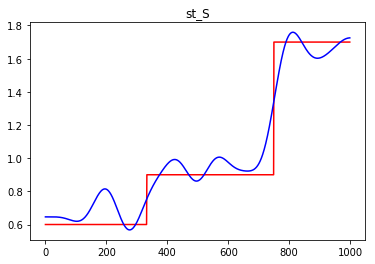

In [9]:
c_2(1000,20,0.5,0.4,0.12,0.7,0.08,1000)

Compared with the previous result, we find that soft threshold estimation also performance well, better than MLE and similar with EF estimation.

# Application

In [12]:
def read_data(url):
    f=open(url)
    k=0
    for line in f.readlines():
        if k==0:
            a=line.find("S")
            line=line[a:].split()
            raw_data=pd.DataFrame(columns=line)
            k=k+1
        else:
            a=line.find("1")
            b=line.find("0")
            line=line[min(a,b):].split()
            raw_data.loc[k]=line
            k=k+1
    raw_data=raw_data[['logYL','Latitude']]
    raw_data=(raw_data.apply(pd.to_numeric,errors='coerce')).dropna()
    y=np.array(raw_data['logYL']).reshape((-1,1))
    x=np.array(raw_data['Latitude']).reshape((-1,1))
    return x,y

def gen_dm(x,K,N):
    Phi=np.ones_like(x)
    for k in range(1,K):
        Phi=np.c_[Phi,x**k]
    q,r=np.linalg.qr(Phi)
    return q*np.sqrt(N)

def gen_z(Phi,y,N):
    return (Phi.T@y)/N

def mle(Phi,z):
    return Phi@z

def gen_sigma(mle,y,N,K):
    #use mle to estimate sigma
    return np.sqrt((mle-y).T@(mle-y)/(N-K))

def st(Phi,z,lam):
    theta=np.where(z>0,1,-1)*np.maximum(np.abs(z)-lam*np.ones_like(z),np.zeros_like(z))
    return Phi@theta

def r_sure_st(N,K,sigma,z):
    v=lambda lam: K*sigma*sigma/N-2*sigma*sigma/N*np.sum(np.where(np.abs(z)<=lam,1,0))+np.sum(np.minimum(z*z,lam*lam*np.ones_like(z)))
    return v

def gen_lam(N,K,sigma,z):
    mini=minimize_scalar(r_sure_st(N,K,sigma,z),method='Golden')
    return mini.x
    
def ef(Phi,z,sigma,K,N):
    c=np.zeros(K)
    for k in range(0,K):
        if z[k]!=0:
            c[k]=np.maximum(1-sigma*sigma/(z[k]*z[k]*N),0)
        else:
            c[k]=0
    return Phi@np.diag(c)@z

def r_sure_os(N,K,sigma,z,M):
    return sigma*sigma*M/N+(z[M:].T)@(z[M:])-(K-M)*sigma*sigma/N

def gen_M(N,K,sigma,z):
    risk=np.zeros(K+1)
    for i in range(K+1):
        risk[i]=r_sure_os(N,K,sigma,z,i)
    return np.argmin(risk)

def ord_sub(Phi,z,M,K):
    for i in range(M,K):
        z[i]=0
    return Phi@z

def plot(x,est,y,method):
    plt.scatter(x, est,s=1, c='b')
    plt.scatter(x, y,s=1, c='r')
    plt.xlabel('latitude')
    plt.ylabel('log GDP per worker')
    plt.title(method+' estimate')
    plt.show()
    
def apply(K,url='HallJones400.asc.txt'):
    x,y=read_data(url)
    N=x.size
    Phi=gen_dm(x,K,N)
    z=gen_z(Phi,y,N)
    e_mle=mle(Phi,z)
    sigma=gen_sigma(e_mle,y,N,K)
    lam=gen_lam(N,K,sigma,z)
    e_st=st(Phi,z,lam)
    M=gen_M(N,K,sigma,z)
    e_os=ord_sub(Phi,z,M,K)
    e_ef=ef(Phi,z,sigma,K,N)
    plot(x,e_mle,y,"MLE")
    plot(x,e_st,y,"ST")
    plot(x,e_os,y,"OS")
    plot(x,e_ef,y,"EF")

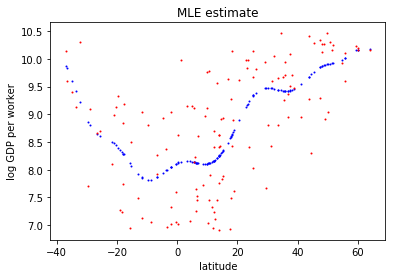

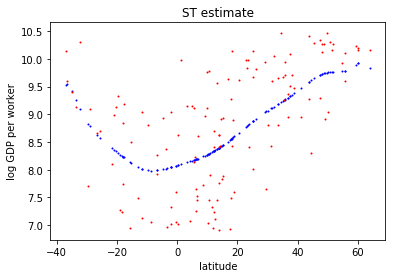

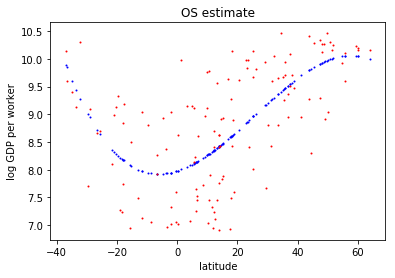

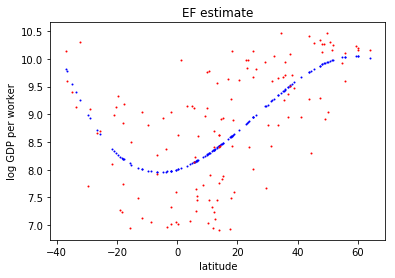

In [13]:
apply(15)

We find that all of the four estimation method has good fit for the given data. And MLE estimation shows more fluctuation and OS and EF estimation is more stable.